This is the notebook for the 46hunnybun project. -- Ver: 1.2

# Preprocessing and Some Attempts at Modeling

In [2]:
import pandas as pd
import numpy as np
import os
def load_abnormal_data(base_path, mass_train, mass_test, calc_train, calc_test):
    try:
        # Load CSV
        df_mass_train = pd.read_csv(os.path.join(base_path, mass_train))
        df_mass_train['split'] = 'Training'

        df_mass_test = pd.read_csv(os.path.join(base_path, mass_test))
        df_mass_test['split'] = 'Test'

        df_calc_train = pd.read_csv(os.path.join(base_path, calc_train))
        df_calc_train['split'] = 'Training'

        df_calc_test = pd.read_csv(os.path.join(base_path, calc_test))
        df_calc_test['split'] = 'Test'

        # Add 'abnormality_type' before concatenating
        df_mass_train['abnormality_type'] = 'Mass'
        df_mass_test['abnormality_type'] = 'Mass'
        df_calc_train['abnormality_type'] = 'Calc'
        df_calc_test['abnormality_type'] = 'Calc'

        # Concatenate all into a single DataFrame
        df_abnormal = pd.concat([df_mass_train, df_mass_test, df_calc_train, df_calc_test], ignore_index=True)

        # Create the linking key for cropped images. Example: Mass-Training_P_00001_LEFT_CC_1
        df_abnormal['PatientID_key_cropped'] = df_abnormal['abnormality_type'] + '-' + \
                                                df_abnormal['split'] + '_' + \
                                                df_abnormal['patient_id'] + '_' + \
                                                df_abnormal['left or right breast'] + '_' + \
                                                df_abnormal['image view'] + '_' + \
                                                df_abnormal['abnormality id'].astype(str)

        # Create the linking key for full mammograms. Example: Mass-Training_P_00001_LEFT_CC
        df_abnormal['PatientID_key_full'] = df_abnormal['abnormality_type'] + '-' + \
                                            df_abnormal['split'] + '_' + \
                                            df_abnormal['patient_id'] + '_' + \
                                            df_abnormal['left or right breast'] + '_' + \
                                            df_abnormal['image view']

        return df_abnormal

    except FileNotFoundError as e:
        print(f"Error loading file: {e}. Make sure all description CSVs are present.")
        return None
    except Exception as e:
        print(f"An error occurred while loading abnormal data: {e}")
        return None


try:

    gdrive_base_path = "4600 Data/"


    df_abnormal = load_abnormal_data(
        gdrive_base_path,
        "mass_case_description_train_set.csv",
        "mass_case_description_test_set.csv",
        "calc_case_description_train_set.csv",
        "calc_case_description_test_set.csv"
    )

    if df_abnormal is not None:
        dicom_info_path = os.path.join(gdrive_base_path, "dicom_info.csv")
        df_dicom_info = pd.read_csv(dicom_info_path)


        # Label cropped imgggg
        df_cropped_labels = df_abnormal[['PatientID_key_cropped', 'pathology']].copy()
        df_cropped_labels.rename(columns={'PatientID_key_cropped': 'PatientID'}, inplace=True)
        df_cropped_labels = df_cropped_labels.drop_duplicates(subset=['PatientID'])

        # Label full imgggg
        df_full_labels = df_abnormal[['PatientID_key_full', 'pathology']].copy()
        df_full_labels.rename(columns={'PatientID_key_full': 'PatientID'}, inplace=True)
        df_full_labels = df_full_labels.drop_duplicates(subset=['PatientID'])

    
        df_merged = pd.merge(df_dicom_info, df_cropped_labels, on='PatientID', how='left')
        df_merged = pd.merge(df_merged, df_full_labels, on='PatientID', how='left', suffixes=('_cropped', '_full'))

        df_merged['pathology'] = df_merged['pathology_cropped'].fillna(df_merged['pathology_full'])
        df_merged.drop(columns=['pathology_cropped', 'pathology_full'], inplace=True)
        image_filter = df_merged['SeriesDescription'].isin(['full mammogram images', 'cropped images'])
        df_merged.loc[image_filter & df_merged['pathology'].isna(), 'pathology'] = 'NORMAL'

        final_df = df_merged.loc[
            image_filter & df_merged['pathology'].notna(),
            ['image_path', 'pathology', 'SeriesDescription']
        ].copy()


        final_df['full_image_path'] = gdrive_base_path + final_df['image_path'].str.replace('CBIS-DDSM/', '', regex=False)


        final_data_manifest = final_df[['full_image_path', 'pathology', 'SeriesDescription']]


        print("--- Final Data Manifest Info ---")
        print(final_data_manifest.info())

        print("\n--- Value Counts for Pathology ---")
        print(final_data_manifest['pathology'].value_counts())

        print("\n--- Value Counts for Image Type ---")
        print(final_data_manifest['SeriesDescription'].value_counts())


        output_filename = "image_pathology_manifest.csv"
        final_data_manifest.to_csv(output_filename, index=False)
        print(f"\nSuccessfully created '{output_filename}' in your Colab environment.")
        print("You can now load this file in your next step.")

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure 'dicom_info.csv' and the other CSVs are in '{gdrive_base_path}'")
except Exception as e:
    print(f"An error occurred during the main execution: {e}")

--- Final Data Manifest Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 6424 entries, 0 to 10236
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   full_image_path    6424 non-null   object
 1   pathology          6424 non-null   object
 2   SeriesDescription  6424 non-null   object
dtypes: object(3)
memory usage: 200.8+ KB
None

--- Value Counts for Pathology ---
pathology
MALIGNANT                  2725
BENIGN                     2660
BENIGN_WITHOUT_CALLBACK    1039
Name: count, dtype: int64

--- Value Counts for Image Type ---
SeriesDescription
cropped images           3567
full mammogram images    2857
Name: count, dtype: int64

Successfully created 'image_pathology_manifest.csv' in your Colab environment.
You can now load this file in your next step.


In [3]:
import pandas as pd
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm

BASE_IMAGE_DIR = "4600 Data\jpeg" 
MANIFEST_PATH = "image_pathology_manifest.csv" 

if os.path.exists(MANIFEST_PATH):
    df = pd.read_csv(MANIFEST_PATH)
    print(f"Loaded manifest with {len(df)} entries.")
else:
    print("Error: Manifest file not found.")
    exit()

print("Indexing local files... (Scanning your folder structure)")
file_map = {} 
for root, dirs, files in os.walk(BASE_IMAGE_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_map[file] = os.path.join(root, file)

print(f"Index complete. Found {len(file_map)} images in your local folders.")

# Filter for cropped
if 'SeriesDescription' in df.columns:
    df_cropped = df[df['SeriesDescription'] == 'cropped images'].copy()
else:
    df_cropped = df.copy()

if 'pathology' in df_cropped.columns:
    df_cropped['label'] = df_cropped['pathology'].replace({'BENIGN_WITHOUT_CALLBACK': 'BENIGN'})

images = []
labels = []
IMG_SIZE = 224

print(f"Starting to load {len(df_cropped)} images...")
print("-" * 50)

for i, row in enumerate(df_cropped.iterrows()):
    _, data = row
    
    csv_path = data['full_image_path']
    filename = os.path.basename(csv_path)
    
    if filename in file_map:
        local_path = file_map[filename]
        
        print(f"[{i+1}] Loading: {filename}") 
        # -------------------------

        try:
            img = cv2.imread(local_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"    >>> FAILED: {filename} (File corrupt or unreadable)")
                continue 
            
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            
            images.append(img)
            labels.append(data['label'])
            
        except Exception as e:
            print(f"    >>> ERROR on {filename}: {e}")
    else:
        print(f"[{i+1}] SKIPPING: {filename} (Not found in your folder)")


print("-" * 50)
X = np.array(images)
y = np.array(labels)

if X.size > 0:
    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    print(f"DONE!")
    print(f"Images Loaded: {X.shape}")
    print(f"Labels Loaded: {y.shape}")
else:
    print("No images were successfully loaded.")

Loaded manifest with 6424 entries.
Indexing local files... (Scanning your folder structure)
Index complete. Found 608 images in your local folders.
Starting to load 3567 images...
--------------------------------------------------
[1] Loading: 1-172.jpg
[2] Loading: 1-052.jpg
[3] Loading: 1-034.jpg
[4] Loading: 1-149.jpg
[5] Loading: 1-003.jpg
[6] Loading: 1-085.jpg
[7] Loading: 2-242.jpg
[8] Loading: 1-171.jpg
[9] Loading: 1-111.jpg
[10] Loading: 1-151.jpg
[11] Loading: 1-104.jpg
[12] Loading: 1-228.jpg
[13] Loading: 1-000.jpg
[14] Loading: 1-071.jpg
[15] Loading: 1-012.jpg
[16] Loading: 1-012.jpg
[17] Loading: 2-213.jpg
[18] Loading: 1-176.jpg
[19] Loading: 1-208.jpg
[20] Loading: 1-202.jpg
[21] Loading: 1-049.jpg
[22] Loading: 1-270.jpg
[23] Loading: 1-218.jpg
[24] Loading: 1-215.jpg
[25] Loading: 1-051.jpg
[26] Loading: 1-269.jpg
[27] Loading: 1-072.jpg
[28] Loading: 1-033.jpg
[29] Loading: 1-098.jpg
[30] Loading: 1-229.jpg
[31] Loading: 1-204.jpg
[32] Loading: 1-290.jpg
[33] Loadi

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# LABEL ENCODING LABEL ENCODING
le = LabelEncoder()
y_encoded = le.fit_transform(y)


TEST_SPLIT_SIZE = 0.20

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_encoded,
    test_size=TEST_SPLIT_SIZE,
    random_state=42, 
    stratify=y_encoded
)

VALIDATION_SPLIT_SIZE = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VALIDATION_SPLIT_SIZE,
    random_state=42,
    stratify=y_train_full 
)


print(f"Original X shape: {X.shape}")
print(f"Original y shape: {y_encoded.shape}\n")

print(f"Training X shape:   {X_train.shape}")
print(f"Training y shape:   {y_train.shape}\n")

print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}\n")

print(f"Test X shape:       {X_test.shape}")
print(f"Test y shape:       {y_test.shape}")

c:\Users\jrauf\AppData\Local\anaconda3\envs\4600env\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Original X shape: (3563, 224, 224, 1)
Original y shape: (3563,)

Training X shape:   (2137, 224, 224, 1)
Training y shape:   (2137,)

Validation X shape: (713, 224, 224, 1)
Validation y shape: (713,)

Test X shape:       (713, 224, 224, 1)
Test y shape:       (713,)


C:\Users\jrauf\AppData\Local\Temp\ipykernel_21176\2883006284.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v, f"{pathology_percentages[i]:.1f}%", ha='center', va='bottom')


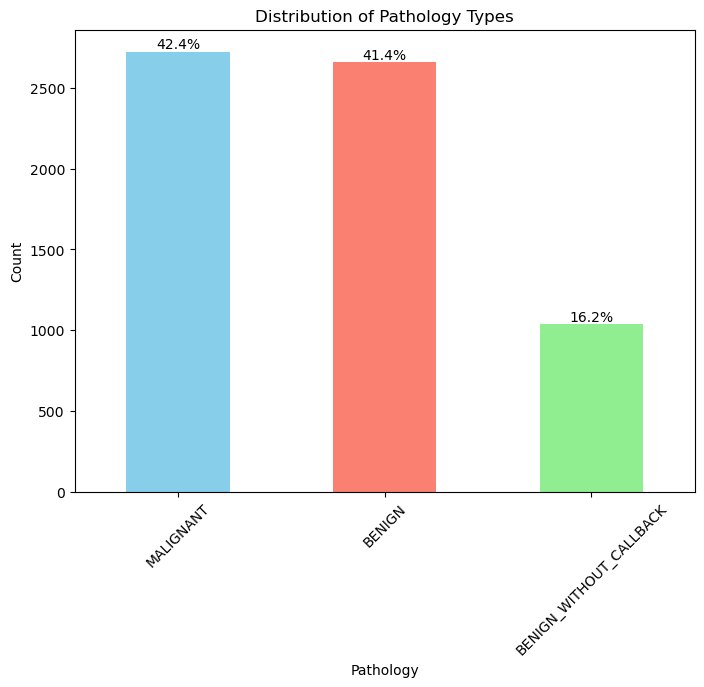

Pathology Counts:
pathology
MALIGNANT                  2725
BENIGN                     2660
BENIGN_WITHOUT_CALLBACK    1039
Name: count, dtype: int64

Pathology Percentages:
pathology
MALIGNANT                  42.419054
BENIGN                     41.407223
BENIGN_WITHOUT_CALLBACK    16.173724
Name: count, dtype: float64


In [5]:
import matplotlib.pyplot as plt
pathology_counts = final_data_manifest['pathology'].value_counts()
total_samples = len(final_data_manifest)
pathology_percentages = (pathology_counts / total_samples) * 100
plt.figure(figsize=(8, 6))
ax = pathology_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Pathology Types')
plt.xlabel('Pathology')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, v in enumerate(pathology_counts):
    ax.text(i, v, f"{pathology_percentages[i]:.1f}%", ha='center', va='bottom')
plt.show()
print("Pathology Counts:")
print(pathology_counts)
print("\nPathology Percentages:")
print(pathology_percentages)

In [5]:
# 1. Define the augmentation layers
# These will run on the GPU, making them very fast.
data_augmentation = tf.keras.Sequential([
    # Add 'input_shape' only if this is the first layer of your model
    # tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)),

    # random rotations
    tf.keras.layers.RandomRotation(0.1),  # rotate by +/- 10%

    # horizontal flips
    tf.keras.layers.RandomFlip("horizontal"),

    # scaling (zoom)
    tf.keras.layers.RandomZoom(0.1), # zoom in/out by +/- 10%

    # slight adjustments in brightness and contrast
    tf.keras.layers.RandomBrightness(0.1), # adjust brightness by +/- 10%
    tf.keras.layers.RandomContrast(0.1)  # adjust contrast by +/- 10%
], name="data_augmentation")


# 2. tf.data pipelines
BATCH_SIZE = 32

# datasets from your NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# augmentation ONLY to the training set
train_ds = train_ds.shuffle(buffer_size=len(X_train)) \
                   .batch(BATCH_SIZE) \
                   .map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE) \
                   .prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation and Test sets: DO NOT augment. Just batch and prefetch
val_ds = val_ds.batch(BATCH_SIZE) \
               .prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.batch(BATCH_SIZE) \
                 .prefetch(buffer_size=tf.data.AUTOTUNE)

print("\nSuccessfully created tf.data pipelines.")
print(f"Training dataset:   {train_ds}")
print(f"Validation dataset: {val_ds}")
print(f"Test dataset:       {test_ds}")


Successfully created tf.data pipelines.
Training dataset:   <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test dataset:       <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm.auto import tqdm

BASE_PATH = "4600 Data/" 

print("--- Step 1: Merging Metadata ---")
try:
    dicom_info = pd.read_csv(os.path.join(BASE_PATH, 'dicom_info.csv'))
    calc_test = pd.read_csv(os.path.join(BASE_PATH, 'calc_case_description_test_set.csv'))
    calc_train = pd.read_csv(os.path.join(BASE_PATH, 'calc_case_description_train_set.csv'))
    mass_test = pd.read_csv(os.path.join(BASE_PATH, 'mass_case_description_test_set.csv'))
    mass_train = pd.read_csv(os.path.join(BASE_PATH, 'mass_case_description_train_set.csv'))
    calc_test['type'] = 'Calc-Test'
    calc_train['type'] = 'Calc-Training'
    mass_test['type'] = 'Mass-Test'
    mass_train['type'] = 'Mass-Training'
    cases = pd.concat([calc_test, calc_train, mass_test, mass_train], ignore_index=True)

    cases['join_key'] = cases.apply(
        lambda x: f"{x['type']}_{x['patient_id']}_{x['left or right breast']}_{x['image view']}_{x['abnormality id']}",
        axis=1
    )

    # Removes Masks
    dicom_crops = dicom_info[dicom_info['SeriesDescription'] == 'cropped images'].copy()

    df_initial = pd.merge(cases, dicom_crops, left_on='join_key', right_on='PatientID', how='inner')
    
    df_initial['target'] = df_initial['pathology'].apply(lambda x: 1 if 'MALIGNANT' in x else 0)
    
    print(f"Metadata Merged. Entries: {len(df_initial)}")

except FileNotFoundError:
    print(f"CRITICAL ERROR: Could not find CSV files in '{BASE_PATH}'. Check your folder structure.")
    raise

print("\n--- Step 2: Fixing File Paths (The Scanner) ---")
image_map = {}
print(f"Scanning '{BASE_PATH}' for images... (This usually takes < 1 min)")

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            parent = os.path.basename(root)
            key = f"{parent}/{file}"
            image_map[key] = os.path.join(root, file)

print(f"Found {len(image_map)} images on disk.")

def find_real_path(csv_path):
    parts = csv_path.split('/')
    if len(parts) >= 2:
        key = f"{parts[-2]}/{parts[-1]}"
        if key in image_map:
            return image_map[key]
    return None

df_initial['real_path'] = df_initial['image_path'].apply(find_real_path)

df_final = df_initial[df_initial['real_path'].notna()].copy()
print(f"Successfully Matched: {len(df_final)} images.")
print(f"Dropped (Missing): {len(df_initial) - len(df_final)}")

df_final.to_csv('final_clean_manifest_fixed.csv', index=False)
print("\n✅ SUCCESS: 'final_clean_manifest_fixed.csv' created.")
print("You can now run the Final Pipeline code.")

--- Step 1: Merging Metadata ---
Metadata Merged. Entries: 3567

--- Step 2: Fixing File Paths (The Scanner) ---
Scanning '4600 Data/' for images... (This usually takes < 1 min)
Found 3575 images on disk.
Successfully Matched: 1235 images.
Dropped (Missing): 2332

✅ SUCCESS: 'final_clean_manifest_fixed.csv' created.
You can now run the Final Pipeline code.


# Check for GPU

In [6]:
# CUDA CUDA CUDA CUDA CUDA CUDA CUDA CUDA CUDA CUDADX ACUacuACUacwqa
import torch
print(torch.cuda.is_available())

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4060


# Baseline CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, accuracy_score


class MammoDataset(Dataset):
    def __init__(self, images, labels):
        # images are (N, H, W, C) and need (N, C, H, W)
        # permute the dimensions: (0, 3, 1, 2)
        self.X = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
        # Labels for CrossEntropyLoss need to be LongTensors
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#  CNN Arch

class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        # Input shape: (Batch, 1, 224, 224)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # curr Shape: (Batch, 16, 224, 224)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # curr Shape: (Batch, 16, 112, 112)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Shape: (Batch, 32, 112, 112)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # curr Shape: (Batch, 32, 56, 56)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # curr Shape: (Batch, 64, 56, 56)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # curr Shape: (Batch, 64, 28, 28)

        # Flatten the output for the fully-connected layers
        # 64 channels * 28 * 28 = 50,176
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.relu4 = nn.ReLU()

        # Output layer: 2 classes (BENIGN, MALIGNANT)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

train_dataset = MammoDataset(X_train, y_train)
val_dataset = MammoDataset(X_val, y_val)

BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# model, loss, and optimizer
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss() # Handles softmax internally
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model architecture:")
print(model)
print("\nStarting training...")

NUM_EPOCHS = 10 # NOTE edit

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * images.size(0)
            val_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")


print("\nTraining complete.")
print("Final Validation Results:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

Using device: cuda

Model architecture:
BaseCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

Starting training...
Epoch 1/10 | Train Loss: 0.6989 | Val Loss: 0.6757 | Val Acc: 0.5919
Epoch 2/10 | Train Loss: 0.6771 | Val Loss: 0.6795 | Val Acc: 0.5919
Epoch 3/10 | Train Loss: 0.6755 | Val Loss: 0.6735 | Val Ac

# ResNet 50

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import torchvision.models as models
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class MammoDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.X = images
        self.y = torch.tensor(labels, dtype=torch.long)
        self.transform = transform
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.transform(self.X[idx]), self.y[idx]

# --- 3. Model Setup with BN/ReLU Head ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# FREEZING LAYERS (Optional but recommended for small medical datasets)
# Uncomment the loop below to freeze the early layers and only train the new head
# for param in model.parameters():
#     param.requires_grad = False

num_features = model.fc.in_features

# Custom Head with Batch Norm and ReLU
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512), # Added Batch Norm
    nn.ReLU(),           # Added ReLU
    nn.Dropout(0.4),
    nn.Linear(512, 2)
)

model = model.to(device)

# --- 4. Helper Function: LR Finder ---
def simple_lr_finder(model, train_loader, criterion, optimizer, device):
    """
    Runs a rough LR range test to help you pick an optimal learning rate.
    """
    print("Running LR Finder...")
    model.train()
    lrs = []
    losses = []
    
    # Start very small, end very large
    lr_start = 1e-7
    lr_end = 10
    num_steps = 100
    
    # Calculate multiplier
    gamma = (lr_end / lr_start) ** (1 / num_steps)
    
    optimizer.param_groups[0]['lr'] = lr_start
    current_lr = lr_start
    
    # Save initial weights so we can reset after the test
    initial_state = model.state_dict()
    
    iterator = iter(train_loader)
    
    for i in range(num_steps):
        try:
            images, labels = next(iterator)
        except StopIteration:
            iterator = iter(train_loader)
            images, labels = next(iterator)
            
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Record
        lrs.append(current_lr)
        losses.append(loss.item())
        
        # Update LR
        current_lr *= gamma
        optimizer.param_groups[0]['lr'] = current_lr
        
        # Stop if loss explodes
        if i > 10 and loss.item() > 4 * min(losses):
            break

    # Restore model to state before test
    model.load_state_dict(initial_state)
    print("LR Finder complete. Model weights restored.")
    
    # Plot results
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('LR Finder Results')
    plt.show()
    print("Look at the graph. Pick the LR where the curve is slumping DOWN steepestly (usually 10x smaller than the lowest point).")

# --- 5. Setup for Training ---
# Setup DataLoaders (Assuming X_train, y_train exist)
BATCH_SIZE = 32
train_dataset = MammoDataset(X_train, y_train, transform=train_transforms)
val_dataset = MammoDataset(X_val, y_val, transform=val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights[1] = class_weights[1] * 1.2 # Slightly increased penalty
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=1e-7) # Temp LR for finder

# --- RUN THE FINDER ---
#  - This logic will generate a plot similar to standard LR finder tools
simple_lr_finder(model, train_loader, criterion, optimizer, device)

# --- 6. Actual Training ---
# 1. Update this value based on the graph you just saw!
OPTIMAL_LR = 0.0001 
print(f"Training with selected LR: {OPTIMAL_LR}")

optimizer = optim.Adam(model.parameters(), lr=OPTIMAL_LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# ... Proceed with your existing training loop ...

Running LR Finder...


TypeError: pic should be Tensor or ndarray. Got <class 'str'>.

In [13]:
import os
import pandas as pd
import glob
from tqdm.auto import tqdm

SEARCH_ROOT = "4600 Data/" 


image_map = {}
for root, dirs, files in os.walk(SEARCH_ROOT):
    for file in files:
        if file.endswith(".jpg"):
            parent_folder = os.path.basename(root)
            key = f"{parent_folder}/{file}"
            image_map[key] = os.path.join(root, file)

print(f"Found {len(image_map)} images in your folder.")

# 2. Update the Manifest
df = pd.read_csv('final_clean_manifest_v2.csv')
print(f"Manifest has {len(df)} entries.")

def find_real_path(csv_path):
    parts = csv_path.split('/')
    if len(parts) >= 2:
        key = f"{parts[-2]}/{parts[-1]}"
        if key in image_map:
            return image_map[key]
    return None

print("Linking CSV entries to real files...")
df['real_path'] = df['full_image_path'].apply(find_real_path)

df_found = df[df['real_path'].notna()].copy()
missing_count = len(df) - len(df_found)

print(f"Matched: {len(df_found)}")
print(f"Missing: {missing_count} (These will be dropped)")

if len(df_found) < 100:
    print("CRITICAL ERROR: Almost no images matched. Check your SEARCH_ROOT.")
else:
    df_found.to_csv('final_clean_manifest_fixed.csv', index=False)
    
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader
    
    X_paths_fixed = df_found['real_path'].values
    y_labels_fixed = df_found['target'].values
    
    X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_paths_fixed, y_labels_fixed, test_size=0.2, random_state=42, stratify=y_labels_fixed)
    
    train_ds_f = CleanMammoDatasetV2(X_train_f, y_train_f, transform=train_transforms_v2)
    val_ds_f = CleanMammoDatasetV2(X_val_f, y_val_f, transform=val_transforms_v2)
    
    train_loader_f = DataLoader(train_ds_f, batch_size=32, shuffle=True)
    val_loader_f = DataLoader(val_ds_f, batch_size=32, shuffle=False)
    
    print("\nDataLoaders updated. Restarting Training...")
    
    model_v2 = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    # Unfreeze
    for param in model_v2.parameters():
        param.requires_grad = True
    # Head
    model_v2.classifier = nn.Sequential(
        nn.Linear(model_v2.classifier.in_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 2)
    )
    model_v2 = model_v2.to(device)
    
    optimizer_f = optim.Adam(model_v2.parameters(), lr=1e-4)
    criterion_f = nn.CrossEntropyLoss(weight=weights_tensor) # Use previous weights
    scaler_f = torch.amp.GradScaler('cuda')
    
    EPOCHS = 15
    for epoch in range(EPOCHS):
        model_v2.train()
        train_loss = 0.0
        loop = tqdm(train_loader_f, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
        
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer_f.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model_v2(images)
                loss = criterion_f(outputs, labels)
            scaler_f.scale(loss).backward()
            scaler_f.step(optimizer_f)
            scaler_f.update()
            train_loss += loss.item() * images.size(0)
            loop.set_postfix(loss=loss.item())
            
        # Validation
        model_v2.eval()
        val_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader_f:
                images, labels = images.to(device), labels.to(device)
                outputs = model_v2(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader_f.dataset):.4f} | Val Acc: {val_correct/total:.4f}")

Found 3575 images in your folder.


FileNotFoundError: [Errno 2] No such file or directory: 'final_clean_manifest_v2.csv'

Generating predictions...


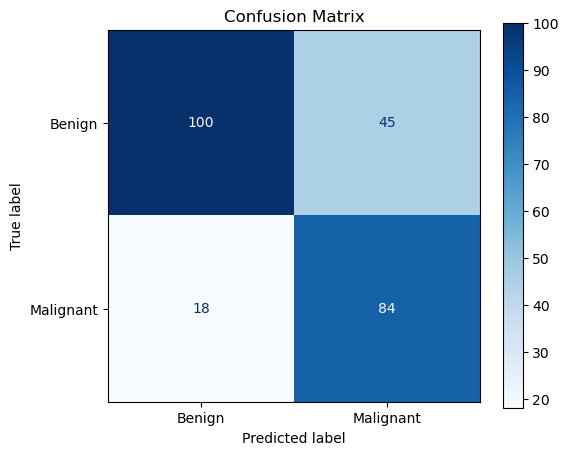


Classification Report:
              precision    recall  f1-score   support

      Benign       0.85      0.69      0.76       145
   Malignant       0.65      0.82      0.73       102

    accuracy                           0.74       247
   macro avg       0.75      0.76      0.74       247
weighted avg       0.77      0.74      0.75       247



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_detailed_metrics(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Generating predictions...")
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Confusion Matrix (Using sklearn's built-in display, no seaborn required)
    cm = confusion_matrix(all_labels, all_preds)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

# Run the metrics check
plot_detailed_metrics(model_v2, val_loader_f, device)

Patching model forward pass...
Running Robust Grad-CAM...


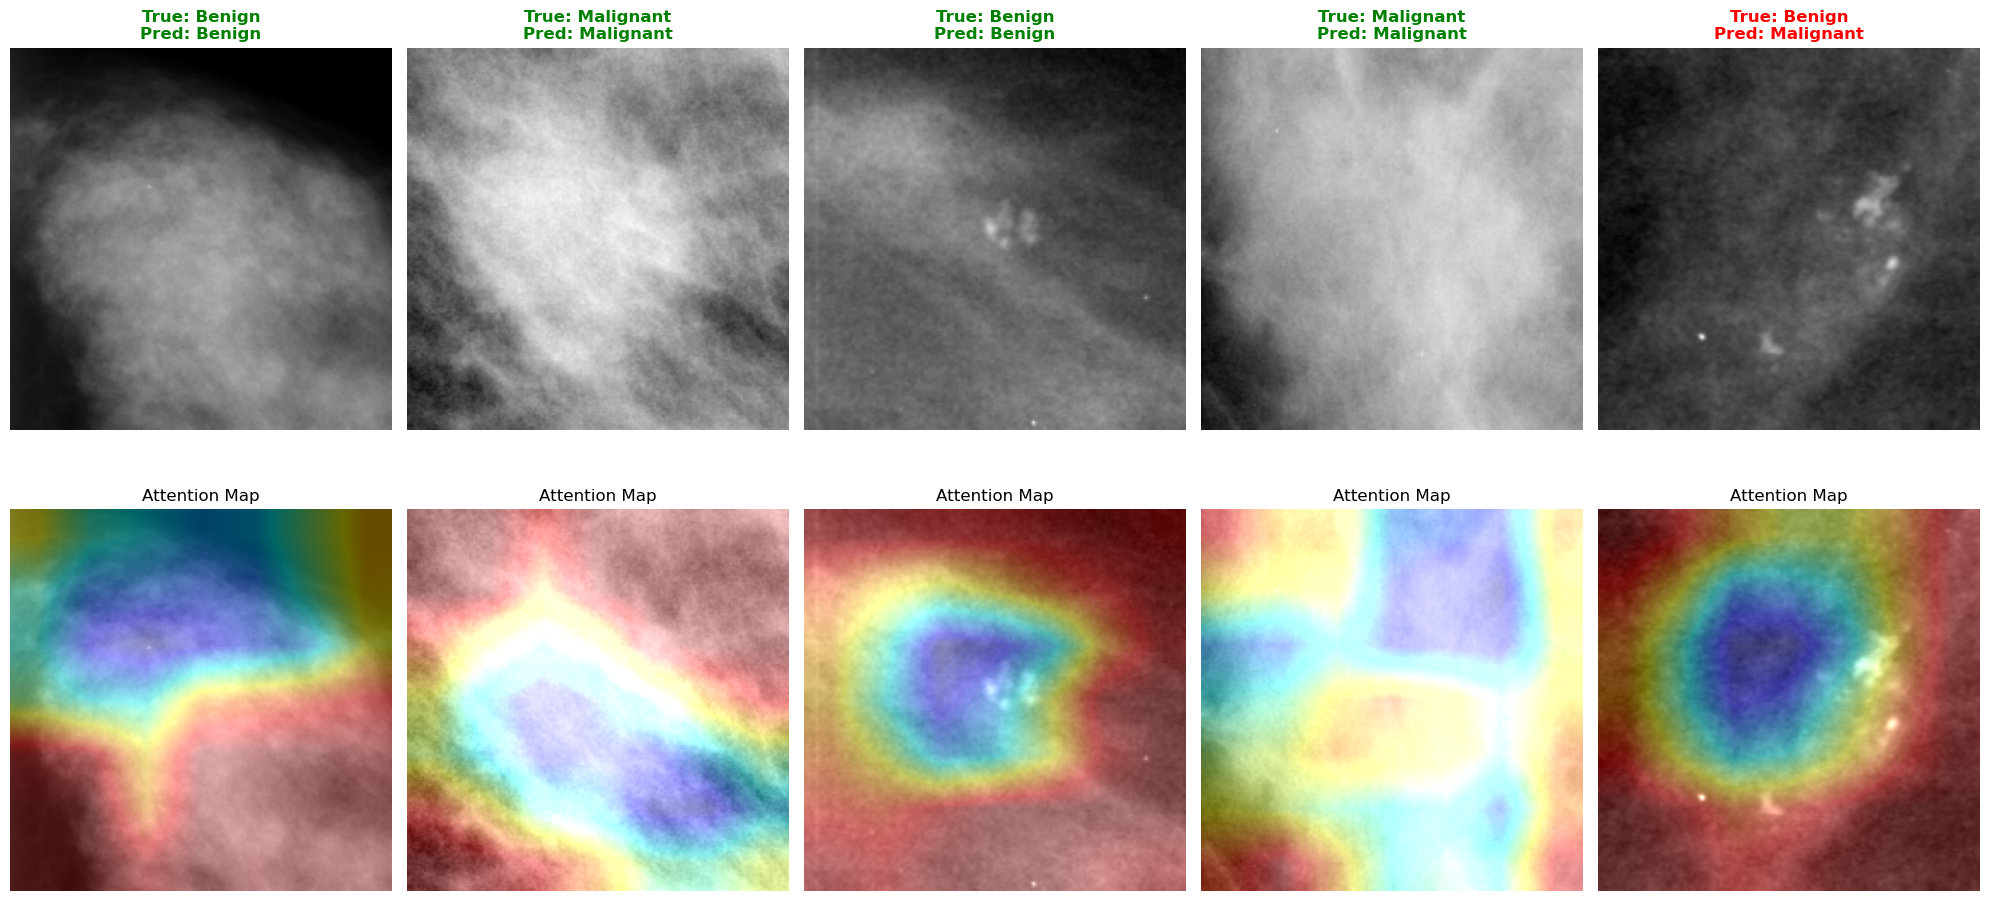

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import types

def safe_densenet_forward(self, x):

    features = self.features(x)
    out = F.relu(features, inplace=False) 
    out = F.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    out = self.classifier(out)
    return out
model_v2.forward = types.MethodType(safe_densenet_forward, model_v2)
for module in model_v2.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace = False

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_forward_hook(self.register_grad_hook)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def register_grad_hook(self, module, input, output):
        def hook_fn(grad):
            self.gradients = grad
        output.register_hook(hook_fn)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)
            
        target = output[0][class_idx]
        target.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0) 
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
        return heatmap

def visualize_gradcam(model, loader, device):
    model.eval()
    
    try:
        images, labels = next(iter(loader))
    except StopIteration:
        print("Loader is empty!")
        return

    images = images.to(device)
    
    target_layer = model.features.norm5
    cam = GradCAM(model, target_layer)
    
    plt.figure(figsize=(20, 10))
    num_images = min(5, len(images))
    
    for i in range(num_images):
        img_tensor = images[i].unsqueeze(0)
        
        with torch.set_grad_enabled(True):
            output = model(img_tensor)
            _, pred = torch.max(output, 1)
            pred_idx = pred.item()
            true_label = labels[i].item()
            
            heatmap = cam(img_tensor, class_idx=pred_idx)
        
        # Image Processing
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5 
        img = np.clip(img, 0, 1)
        img_uint8 = (img * 255).astype(np.uint8)
        heatmap = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
        superimposed_img = heatmap * 0.4 + img_uint8
        superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8) / 255.0
        

        class_names = ['Benign', 'Malignant']
        
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        color = 'green' if pred_idx == true_label else 'red'
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_idx]}", color=color, fontweight='bold')
        plt.axis('off')
        
        # CAM oclock
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(superimposed_img)
        plt.title("Attention Map")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

visualize_gradcam(model_v2, val_loader_f, device)

Cleaning up model hooks...
Model hooks cleared. Ready for analysis.
Calculating probabilities for ROC Curve...

--- STRATEGY REPORT ---
Current AUC: 0.80
To catch 90% of cancers (90% Recall), set threshold to: 0.2829


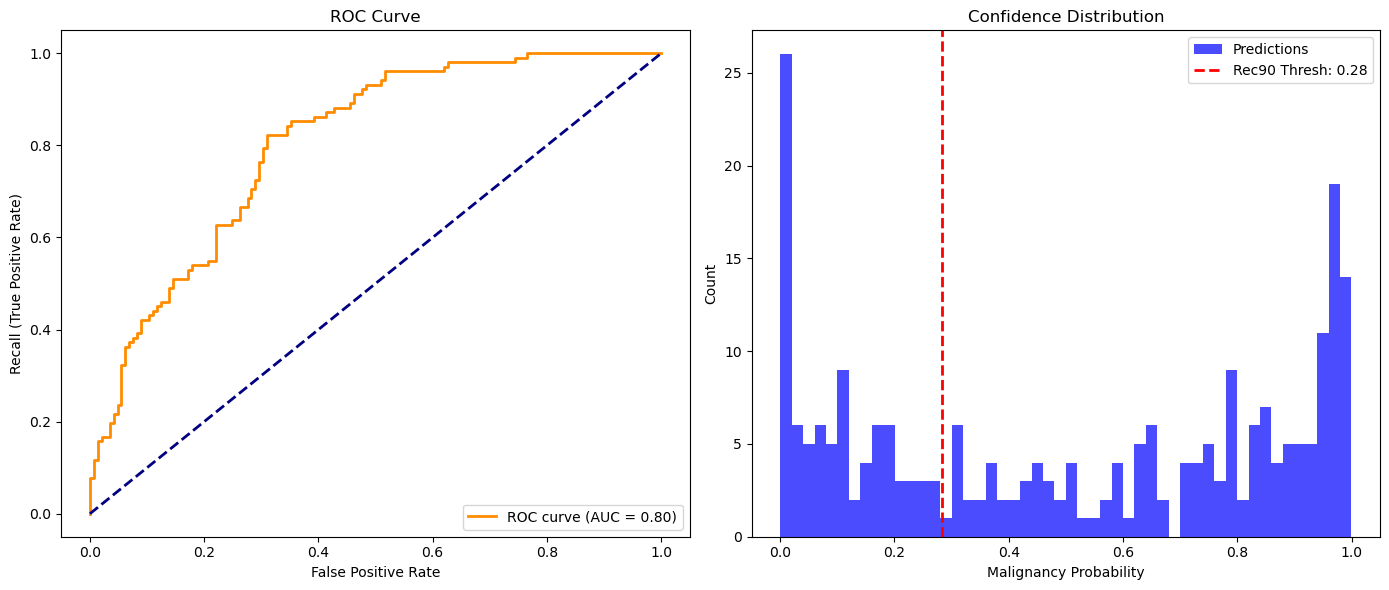


--- Analysing Missed Cancers (False Negatives) ---


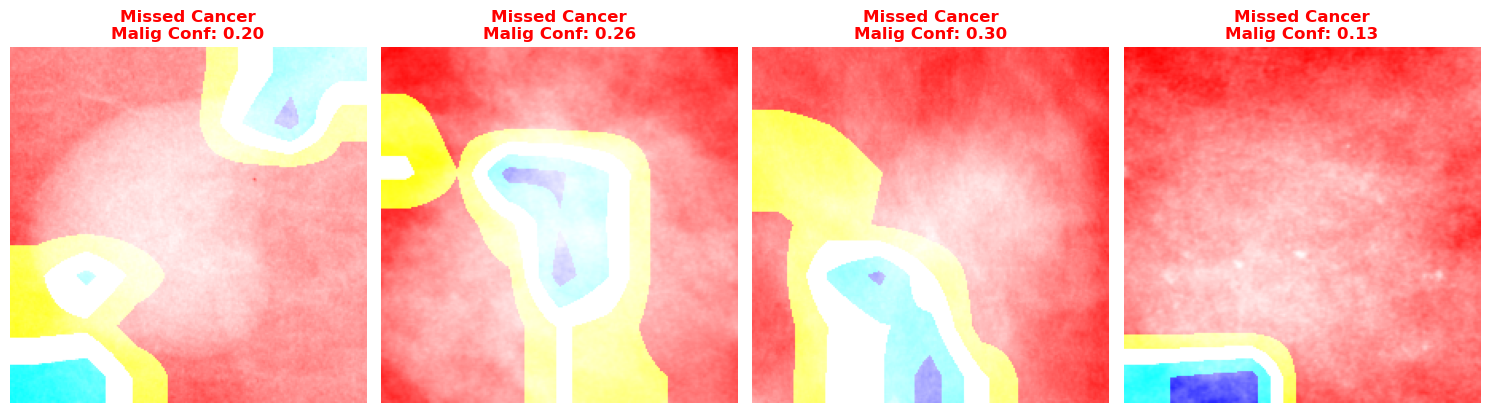

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
import cv2
import numpy as np

try:
    model_v2.features.norm5._forward_hooks.clear()
    model_v2.features.norm5._backward_hooks.clear()
except Exception as e:
    print(f"Cleanup warning: {e}")


def plot_optimization_curves(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Softmaxxing
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall (True Positive Rate)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    

    valid_indices = np.where(tpr >= 0.9)[0] 
    if len(valid_indices) > 0:
        idx = valid_indices[0] 
        optimal_thresh = thresholds[idx]
        
        print(f"\n--- STRATEGY REPORT ---")
        print(f"Current AUC: {roc_auc:.2f}")
        print(f"To catch 90% of cancers (90% Recall), set threshold to: {optimal_thresh:.4f}")
        
        #Histogram
        plt.subplot(1, 2, 2)
        plt.hist(all_probs, bins=50, alpha=0.7, color='blue', label='Predictions')
        plt.axvline(optimal_thresh, color='red', linestyle='dashed', linewidth=2, label=f'Rec90 Thresh: {optimal_thresh:.2f}')
        plt.xlabel('Malignancy Probability')
        plt.ylabel('Count')
        plt.title('Confidence Distribution')
        plt.legend()
    else:
        print("Could not find a threshold for 90% recall.")
    
    plt.tight_layout()
    plt.show()


plot_optimization_curves(model_v2, val_loader_f, device)

class GradCAM_Temp:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        self.handle1 = target_layer.register_forward_hook(self.save_activation)
        self.handle2 = target_layer.register_forward_hook(self.register_grad_hook)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def register_grad_hook(self, module, input, output):
        def hook_fn(grad):
            self.gradients = grad
        output.register_hook(hook_fn)
        
    def remove_hooks(self):
        self.handle1.remove()
        self.handle2.remove()

    def __call__(self, x, class_idx=1):
        self.model.zero_grad()
        output = self.model(x)
        target = output[0][class_idx]
        target.backward()
        
        grads = torch.mean(self.gradients, dim=[0, 2, 3])
        acts = self.activations[0]
        for i in range(acts.shape[0]):
            acts[i] *= grads[i]
        heatmap = torch.mean(acts, dim=0).cpu().detach().numpy()
        return np.maximum(heatmap, 0)

def visualize_false_negatives(model, loader, device):
    print("\n--- Analysing Missed Cancers (False Negatives) ---")
    model.eval()
    
    # CAM
    cam = GradCAM_Temp(model, model.features.norm5)
    
    found = 0
    plt.figure(figsize=(15, 6))
    
    # find errors
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        with torch.set_grad_enabled(True):
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            # Identify Misses (True: 1, Pred: 0)
            misses = (labels == 1) & (preds == 0)
            
            if not misses.any():
                continue
            
            # Get index of first miss
            idx = torch.where(misses)[0][0]
            
            heatmap = cam(images[idx].unsqueeze(0), class_idx=1)
            img = images[idx].cpu().permute(1, 2, 0).numpy()
            img = img * 0.5 + 0.5
            img_uint8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)
            heatmap = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
            heatmap = np.uint8(255 * heatmap / np.max(heatmap)) if np.max(heatmap) > 0 else np.zeros_like(img_uint8[:,:,0])
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            
            overlay = heatmap * 0.4 + img_uint8 / 255.0
            
            # Plot
            ax = plt.subplot(1, 4, found + 1)
            plt.imshow(np.clip(overlay, 0, 1))
            conf = probs[idx, 1].item()
            plt.title(f"Missed Cancer\nMalig Conf: {conf:.2f}", color='red', fontweight='bold')
            plt.axis('off')
            
            found += 1
            if found >= 4:
                break
    
    cam.remove_hooks() 
    
    if found == 0:
        print("No False Negatives found in this batch sweep!")
    else:
        plt.tight_layout()
        plt.show()

visualize_false_negatives(model_v2, val_loader_f, device)

# V3 type shorts


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
import torchvision.models as models
from torchvision import transforms
from tqdm.auto import tqdm

# --- 1. Load Data (Using the FIXED manifest from previous step) ---
print("--- Step 1: Loading Fixed Data for V3 ---")
df_v3 = pd.read_csv('final_clean_manifest_fixed.csv')

# Split (Using same random state for fair comparison)
X_paths_v3 = df_v3['real_path'].values
y_labels_v3 = df_v3['target'].values

X_train_v3, X_val_v3, y_train_v3, y_val_v3 = train_test_split(
    X_paths_v3, y_labels_v3, test_size=0.2, random_state=42, stratify=y_labels_v3
)

# --- 2. V3 Transforms (The "Zoom & Focus" Strategy) ---
train_transforms_v3 = transforms.Compose([
    transforms.ToPILImage(),
    # IMPACT: Randomly zooms into 80-100% of the image. 
    # This forces the model to learn texture, not just edges.
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30), # Increased rotation for robustness
    transforms.RandomAutocontrast(p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Validation stays standard (No random cropping, just resize)
val_transforms_v3 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --- 3. Dataset Class V3 ---
class MammoDatasetV3(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = cv2.imread(path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8) # Safety fallback
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Loaders
train_ds_v3 = MammoDatasetV3(X_train_v3, y_train_v3, transform=train_transforms_v3)
val_ds_v3 = MammoDatasetV3(X_val_v3, y_val_v3, transform=val_transforms_v3)

train_loader_v3 = DataLoader(train_ds_v3, batch_size=32, shuffle=True)
val_loader_v3 = DataLoader(val_ds_v3, batch_size=32, shuffle=False)

# --- 4. Model V3 Setup (DenseNet121) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Step 2: Initializing Model V3 on {device} ---")

model_v3 = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Unfreeze All
for param in model_v3.parameters():
    param.requires_grad = True

# Custom Head
num_features = model_v3.classifier.in_features
model_v3.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.6), # Increased Dropout (0.5 -> 0.6) to fight overfitting
    nn.Linear(512, 2)
)

model_v3 = model_v3.to(device)

# Weights & Optimizer
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_v3), y=y_train_v3)
weights_tensor_v3 = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion_v3 = nn.CrossEntropyLoss(weight=weights_tensor_v3)
optimizer_v3 = optim.Adam(model_v3.parameters(), lr=1e-4)
scheduler_v3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_v3, mode='min', factor=0.1, patience=3)
scaler_v3 = torch.amp.GradScaler('cuda')

# --- 5. Training Loop V3 ---
print("--- Step 3: Starting Training V3 ---")
EPOCHS = 15
history_v3 = {'train_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model_v3.train()
    train_loss = 0.0
    loop = tqdm(train_loader_v3, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_v3.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model_v3(images)
            loss = criterion_v3(outputs, labels)
            
        scaler_v3.scale(loss).backward()
        scaler_v3.step(optimizer_v3)
        scaler_v3.update()
        
        train_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = train_loss / len(train_loader_v3.dataset)
    
    # Validation
    model_v3.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader_v3:
            images, labels = images.to(device), labels.to(device)
            outputs = model_v3(images)
            loss = criterion_v3(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            # Standard Accuracy (Threshold 0.5)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    val_acc = correct / total
    val_loss = val_loss / len(val_loader_v3.dataset)
    
    scheduler_v3.step(val_loss)
    history_v3['train_loss'].append(train_loss)
    history_v3['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# --- 6. Quick Comparison Block ---
print("\n--- Comparison: V3 vs Previous Models ---")
# Calculate AUC for V3
model_v3.eval()
probs_v3 = []
labels_v3 = []
with torch.no_grad():
    for images, labels in val_loader_v3:
        images = images.to(device)
        outputs = model_v3(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probs_v3.extend(probs[:, 1].cpu().numpy())
        labels_v3.extend(labels.numpy())

auc_v3 = roc_auc_score(labels_v3, probs_v3)


--- Step 1: Loading Fixed Data for V3 ---
--- Step 2: Initializing Model V3 on cuda ---
--- Step 3: Starting Training V3 ---


Epoch 1/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.7068 | Val Loss: 0.6313 | Val Acc: 0.6437


Epoch 2/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.6323 | Val Loss: 0.6108 | Val Acc: 0.6356


Epoch 3/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.6083 | Val Loss: 0.5941 | Val Acc: 0.6599


Epoch 4/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.6172 | Val Loss: 0.5725 | Val Acc: 0.6680


Epoch 5/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.6001 | Val Loss: 0.5695 | Val Acc: 0.6923


Epoch 6/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.5567 | Val Loss: 0.5593 | Val Acc: 0.6802


Epoch 7/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.5618 | Val Loss: 0.6704 | Val Acc: 0.6518


Epoch 8/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.5435 | Val Loss: 0.5669 | Val Acc: 0.6923


Epoch 9/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.5187 | Val Loss: 0.6051 | Val Acc: 0.7126


Epoch 10/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.5273 | Val Loss: 0.5881 | Val Acc: 0.6761


Epoch 11/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.4904 | Val Loss: 0.5751 | Val Acc: 0.7004


Epoch 12/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.4738 | Val Loss: 0.5706 | Val Acc: 0.7045


Epoch 13/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.4599 | Val Loss: 0.5615 | Val Acc: 0.7126


Epoch 14/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.4594 | Val Loss: 0.5558 | Val Acc: 0.6964


Epoch 15/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.4451 | Val Loss: 0.5608 | Val Acc: 0.6923

--- Comparison: V3 vs Previous Models ---
Model V3 (Zoom Augmented) AUC: 0.7884
Check if this is higher than V2 (which was ~0.79).


Generating predictions for Model V3...


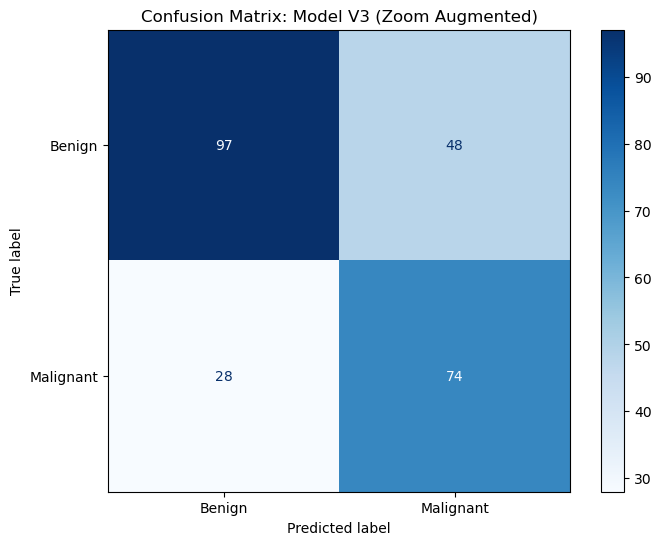


--- Detailed Classification Report ---
              precision    recall  f1-score   support

      Benign       0.78      0.67      0.72       145
   Malignant       0.61      0.73      0.66       102

    accuracy                           0.69       247
   macro avg       0.69      0.70      0.69       247
weighted avg       0.71      0.69      0.69       247



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

def generate_confusion_matrix(model, loader, device):
    print("Generating predictions for Model V3...")
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Standard Prediction (Threshold 0.5)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # 1. Create Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # 2. Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    
    # Plot with darker blues for higher numbers
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Confusion Matrix: Model V3 (Zoom Augmented)')
    plt.show()
    
    # 3. Text Report
    print("\n--- Detailed Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

# Run the function
generate_confusion_matrix(model_v3, val_loader_v3, device)

# V4 skizzle

--- Step 1: Loading Manifest ---

--- Step 2: Caching Data ---
Caching 988 images into RAM... (Wait ~30s)


  0%|          | 0/988 [00:00<?, ?it/s]

Caching 247 images into RAM... (Wait ~30s)


  0%|          | 0/247 [00:00<?, ?it/s]


--- Step 3: Configuring Oversampling ---

--- Step 4: Initializing Model V4 on cuda ---

--- Step 5: Starting Training ---


Epoch 1/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.7283 | Val Loss: 0.6869 | Val Acc: 0.5789


Epoch 2/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.6392 | Val Loss: 0.6730 | Val Acc: 0.6397


Epoch 3/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.6361 | Val Loss: 0.5917 | Val Acc: 0.7166


Epoch 4/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.5837 | Val Loss: 0.5649 | Val Acc: 0.6842


Epoch 5/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.5905 | Val Loss: 0.5784 | Val Acc: 0.7045


Epoch 6/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.5518 | Val Loss: 0.5719 | Val Acc: 0.6559


Epoch 7/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.5663 | Val Loss: 0.5527 | Val Acc: 0.6802


Epoch 8/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.5448 | Val Loss: 0.5977 | Val Acc: 0.6883


Epoch 9/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.5213 | Val Loss: 0.5911 | Val Acc: 0.6923


Epoch 10/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.5068 | Val Loss: 0.6525 | Val Acc: 0.6518


Epoch 11/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.4863 | Val Loss: 0.5946 | Val Acc: 0.6478


Epoch 12/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.4756 | Val Loss: 0.5891 | Val Acc: 0.6518


Epoch 13/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.4669 | Val Loss: 0.5882 | Val Acc: 0.6478


Epoch 14/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.4797 | Val Loss: 0.5778 | Val Acc: 0.6680


Epoch 15/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.4593 | Val Loss: 0.5651 | Val Acc: 0.6964

--- Step 6: Final Evaluation (Confusion Matrix) ---


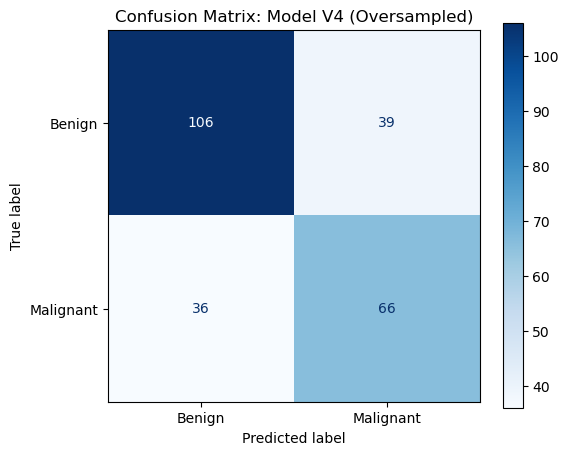

              precision    recall  f1-score   support

      Benign       0.75      0.73      0.74       145
   Malignant       0.63      0.65      0.64       102

    accuracy                           0.70       247
   macro avg       0.69      0.69      0.69       247
weighted avg       0.70      0.70      0.70       247



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torchvision.models as models
from torchvision import transforms
from tqdm.auto import tqdm

# --- 1. CONFIGURATION & DATA LOADING ---
print("--- Step 1: Loading Manifest ---")
# Ensure we use the FIXED manifest (no missing files)
df_v4 = pd.read_csv('final_clean_manifest_fixed.csv')

# Split Data
X_paths = df_v4['real_path'].values
y_labels = df_v4['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    X_paths, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# --- 2. RAM DATASET CLASS (The Speed Fix) ---
class MammoDatasetRAM(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.transform = transform
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.images = [] 
        
        print(f"Caching {len(paths)} images into RAM... (Wait ~30s)")
        for path in tqdm(paths):
            img = cv2.imread(path)
            if img is None: # Safety fallback
                img = np.zeros((224, 224, 3), dtype=np.uint8)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.images.append(img)
            
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# --- 3. TRANSFORMS (Zoom & Focus Strategy) ---
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Zoom Augmentation
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAutocontrast(p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Initialize Datasets (This triggers the RAM caching)
print("\n--- Step 2: Caching Data ---")
train_ds = MammoDatasetRAM(X_train, y_train, transform=train_transforms)
val_ds = MammoDatasetRAM(X_val, y_val, transform=val_transforms)

# --- 4. THE SAMPLER (The "Oversampling" Fix) ---
print("\n--- Step 3: Configuring Oversampling ---")
# 1. Calculate weights for each class (Inverse frequency)
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
# 2. Assign a weight to each sample in the dataset
sample_weights = class_weights[y_train]
# 3. Create Sampler
sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).double(),
    num_samples=len(sample_weights),
    replacement=True
)

# Loaders
# CRITICAL: shuffle=False because sampler is mutually exclusive with shuffle
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# --- 5. MODEL SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n--- Step 4: Initializing Model V4 on {device} ---")

model_v4 = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Unfreeze All
for param in model_v4.parameters():
    param.requires_grad = True

# Classifier Head
model_v4.classifier = nn.Sequential(
    nn.Linear(model_v4.classifier.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.6), # High dropout for regularization
    nn.Linear(512, 2)
)
model_v4 = model_v4.to(device)

# Loss & Optimizer
# NOTE: We REMOVED class_weights from CrossEntropyLoss because the Sampler handles balancing now.
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_v4.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scaler = torch.amp.GradScaler('cuda')

# --- 6. TRAINING LOOP ---
print("\n--- Step 5: Starting Training ---")
EPOCHS = 15

for epoch in range(EPOCHS):
    model_v4.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model_v4(images)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = train_loss / len(train_loader.dataset)
    
    # Validation
    model_v4.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_v4(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    val_acc = correct / total
    val_loss = val_loss / len(val_loader.dataset)
    
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# --- 7. FINAL EVALUATION ---
print("\n--- Step 6: Final Evaluation (Confusion Matrix) ---")
model_v4.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model_v4(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Plot
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix: Model V4 (Oversampled)')
plt.show()

print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

# Best model (✿^‿^) EfficentNetB0

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.models as models
from torchvision import transforms
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import cv2
import os

print("--- Step 1: Reloading Data into PyTorch format ---")

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42) # Call this before splitting data or initializing models

df = pd.read_csv('final_clean_manifest_fixed.csv')
X_paths = df['real_path'].values
y_labels = df['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    X_paths, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAutocontrast(p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 4. Define RAM Dataset Class
class MammoDatasetRAM(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.transform = transform
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.images = [] 
        
        print(f"Caching {len(paths)} images into RAM...")
        for path in tqdm(paths):
            img = cv2.imread(path)
            if img is None: 
                img = np.zeros((224, 224, 3), dtype=np.uint8)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.images.append(img)
            
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# 5. Create Datasets (This fixes the 'AttributeError')
print("Caching Training Data...")
train_ds = MammoDatasetRAM(X_train, y_train, transform=train_transforms)
print("Caching Validation Data...")
val_ds = MammoDatasetRAM(X_val, y_val, transform=val_transforms)

print("\n--- Step 2: Setting up EfficientNet ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


y_train_indices = train_ds.labels.numpy()
class_counts = np.bincount(y_train_indices)
class_weights = 1. / class_counts
class_weights[1] = class_weights[1] * 1.5
sample_weights = class_weights[y_train_indices]

sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).double(),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader_eff = DataLoader(train_ds, batch_size=32, sampler=sampler, shuffle=False)
val_loader_eff = DataLoader(val_ds, batch_size=32, shuffle=False)
model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
for param in model_eff.parameters():
    param.requires_grad = True

num_ftrs = model_eff.classifier[1].in_features
model_eff.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2)
)
model_eff = model_eff.to(device)

optimizer_eff = optim.Adam(model_eff.parameters(), lr=1e-4)
criterion_eff = nn.CrossEntropyLoss()
scaler_eff = torch.amp.GradScaler('cuda')
print("--- Starting Training ---")
EPOCHS = 15

for epoch in range(EPOCHS):
    model_eff.train()
    train_loss = 0.0
    loop = tqdm(train_loader_eff, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_eff.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model_eff(images)
            loss = criterion_eff(outputs, labels)
            
        scaler_eff.scale(loss).backward()
        scaler_eff.step(optimizer_eff)
        scaler_eff.update()
        
        train_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = train_loss / len(train_loader_eff.dataset)
    
    # Validation
    model_eff.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader_eff:
            images, labels = images.to(device), labels.to(device)
            outputs = model_eff(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    val_acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

# Final Report
from sklearn.metrics import classification_report
print("\n--- Evaluation with Adjusted Threshold ---")
model_eff.eval()
all_preds = []
all_labels = []
THRESHOLD = 0.3  # Lower threshold favors Recall (Sensitivity)

with torch.no_grad():
    for images, labels in val_loader_eff:
        images = images.to(device)
        outputs = model_eff(images)
        
        # Get probabilities instead of raw logits
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        # Check if Malignant probability > Threshold
        # probs[:, 1] is the probability of class 1 (Malignant)
        preds = (probs[:, 1] > THRESHOLD).long()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

--- Step 1: Reloading Data into PyTorch format ---
Caching Training Data...
Caching 988 images into RAM...


  0%|          | 0/988 [00:00<?, ?it/s]

Caching Validation Data...
Caching 247 images into RAM...


  0%|          | 0/247 [00:00<?, ?it/s]


--- Step 2: Setting up EfficientNet ---
--- Starting Training ---


Epoch 1/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.6761 | Val Acc: 0.5263


Epoch 2/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.6098 | Val Acc: 0.5870


Epoch 3/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.6058 | Val Acc: 0.5870


Epoch 4/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.5719 | Val Acc: 0.6316


Epoch 5/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.5546 | Val Acc: 0.6397


Epoch 6/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.5493 | Val Acc: 0.6518


Epoch 7/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.5161 | Val Acc: 0.6478


Epoch 8/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.5077 | Val Acc: 0.6599


Epoch 9/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.4830 | Val Acc: 0.6923


Epoch 10/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.4627 | Val Acc: 0.6680


Epoch 11/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.4342 | Val Acc: 0.6842


Epoch 12/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.4524 | Val Acc: 0.6883


Epoch 13/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.4516 | Val Acc: 0.6883


Epoch 14/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.4189 | Val Acc: 0.6680


Epoch 15/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.4007 | Val Acc: 0.6680

--- Evaluation with Adjusted Threshold ---
              precision    recall  f1-score   support

      Benign       0.89      0.43      0.58       145
   Malignant       0.53      0.92      0.67       102

    accuracy                           0.63       247
   macro avg       0.71      0.67      0.63       247
weighted avg       0.74      0.63      0.62       247



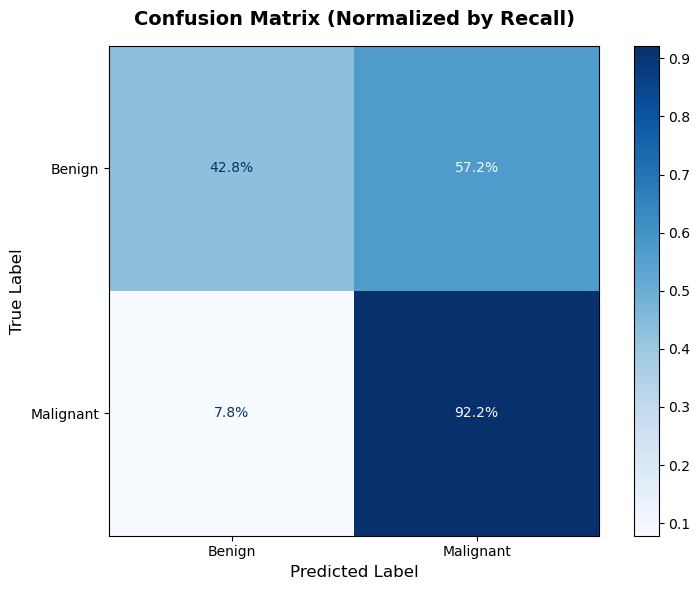

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the Confusion Matrix from the 'all_labels' and 'all_preds' 
# variables created in your previous cell (using the 0.3 threshold)
disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, 
    all_preds, 
    display_labels=['Benign', 'Malignant'],
    cmap='Blues',
    normalize='true',     # <--- Normalizes rows to show Recall/Sensitivity rates
    values_format='.1%',  # <--- Formats as percentage (e.g., 89.1%)
    ax=ax
)

# Styling
ax.set_title('Confusion Matrix (Normalized by Recall)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.grid(False) # Turn off grid lines for a cleaner look

plt.tight_layout()
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.models as models
from tqdm.auto import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

for param in model_eff.parameters():
    param.requires_grad = True

num_ftrs = model_eff.classifier[1].in_features

model_eff.classifier = nn.Sequential(
    nn.Dropout(p=0.5), 
    nn.Linear(num_ftrs, 2)
)

model_eff = model_eff.to(device)

y_train_indices = train_ds.labels.numpy()
class_counts = np.bincount(y_train_indices)
class_weights = 1. / class_counts
sample_weights = class_weights[y_train_indices]

sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).double(),
    num_samples=len(sample_weights),
    replacement=True
)

# Loaders
train_loader_eff = DataLoader(train_ds, batch_size=32, sampler=sampler, shuffle=False)
val_loader_eff = DataLoader(val_ds, batch_size=32, shuffle=False)

#  Optimizer
optimizer_eff = optim.Adam(model_eff.parameters(), lr=1e-4)
criterion_eff = nn.CrossEntropyLoss() # Sampler handles weights
scaler_eff = torch.amp.GradScaler('cuda')

EPOCHS = 15

for epoch in range(EPOCHS):
    model_eff.train()
    train_loss = 0.0
    loop = tqdm(train_loader_eff, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_eff.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model_eff(images)
            loss = criterion_eff(outputs, labels)
            
        scaler_eff.scale(loss).backward()
        scaler_eff.step(optimizer_eff)
        scaler_eff.update()
        
        train_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = train_loss / len(train_loader_eff.dataset)
    
    #Validation
    model_eff.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader_eff:
            images, labels = images.to(device), labels.to(device)
            outputs = model_eff(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    val_acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

from sklearn.metrics import classification_report
print("\n--- EfficientNet Evaluation ---")
model_eff.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader_eff:
        images = images.to(device)
        outputs = model_eff(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

Epoch 1/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.6735 | Val Acc: 0.5749


Epoch 2/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.6395 | Val Acc: 0.6356


Epoch 3/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.5927 | Val Acc: 0.6721


Epoch 4/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.5968 | Val Acc: 0.6842


Epoch 5/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.5479 | Val Acc: 0.7004


Epoch 6/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.5274 | Val Acc: 0.7085


Epoch 7/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.5171 | Val Acc: 0.6680


Epoch 8/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.5010 | Val Acc: 0.7004


Epoch 9/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.5007 | Val Acc: 0.6842


Epoch 10/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.4655 | Val Acc: 0.6883


Epoch 11/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.4789 | Val Acc: 0.6721


Epoch 12/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.4398 | Val Acc: 0.6923


Epoch 13/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.4388 | Val Acc: 0.6802


Epoch 14/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.4227 | Val Acc: 0.7045


Epoch 15/15:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.4080 | Val Acc: 0.7045

--- EfficientNet Evaluation ---
              precision    recall  f1-score   support

      Benign       0.77      0.70      0.74       145
   Malignant       0.63      0.71      0.66       102

    accuracy                           0.70       247
   macro avg       0.70      0.70      0.70       247
weighted avg       0.71      0.70      0.71       247



# EfficentNetB0 with XGBoost

Processing Training Data...
Extracting features from EfficientNet...


  0%|          | 0/31 [00:00<?, ?it/s]

Processing Validation Data...
Extracting features from EfficientNet...


  0%|          | 0/8 [00:00<?, ?it/s]

Feature Shape: (988, 1280) (1280 features per image)

Training XGBoost Classifier...


c:\Users\jrauf\AppData\Local\anaconda3\envs\4600env\lib\site-packages\xgboost\core.py:158: UserWarning: [15:25:31] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluating XGBoost...


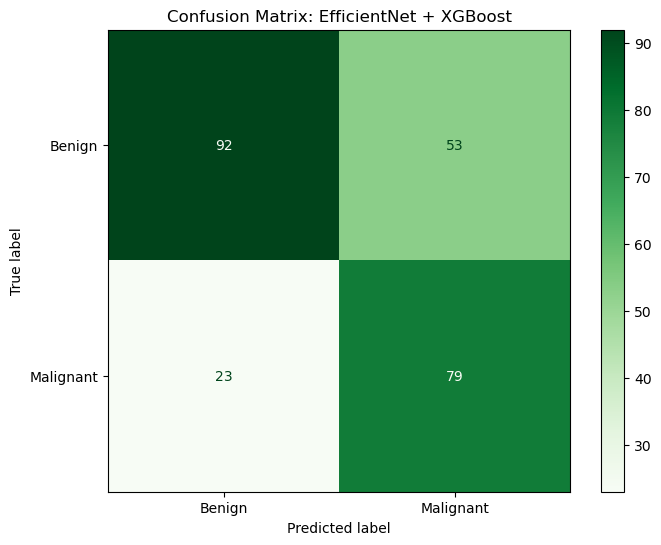


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

      Benign       0.80      0.63      0.71       145
   Malignant       0.60      0.77      0.68       102

    accuracy                           0.69       247
   macro avg       0.70      0.70      0.69       247
weighted avg       0.72      0.69      0.69       247



In [ ]:
import xgboost as xgb
import torch
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(device)
            x = model.features(images)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)
            
            embeddings.append(x.cpu().numpy())
            labels.append(targets.numpy())
            
    X_embed = np.vstack(embeddings)
    y_embed = np.concatenate(labels)
    return X_embed, y_embed


X_train_xgb, y_train_xgb = get_embeddings(model_eff, train_loader_eff, device)

X_val_xgb, y_val_xgb = get_embeddings(model_eff, val_loader_eff, device)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,     #num trees
    max_depth=6,          #depth trees
    learning_rate=0.1,    #step size
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train_xgb, y_train_xgb)


y_pred_xgb = xgb_model.predict(X_val_xgb)


cm = confusion_matrix(y_val_xgb, y_pred_xgb)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Greens', ax=ax) # Using Green to distinguish from Deep Learning plots
plt.title('Confusion Matrix: EfficientNet + XGBoost')
plt.show()

print("\n--- XGBoost Classification Report ---")
print(classification_report(y_val_xgb, y_pred_xgb, target_names=['Benign', 'Malignant']))

# EfficientNetB0 Metrics

Metrics


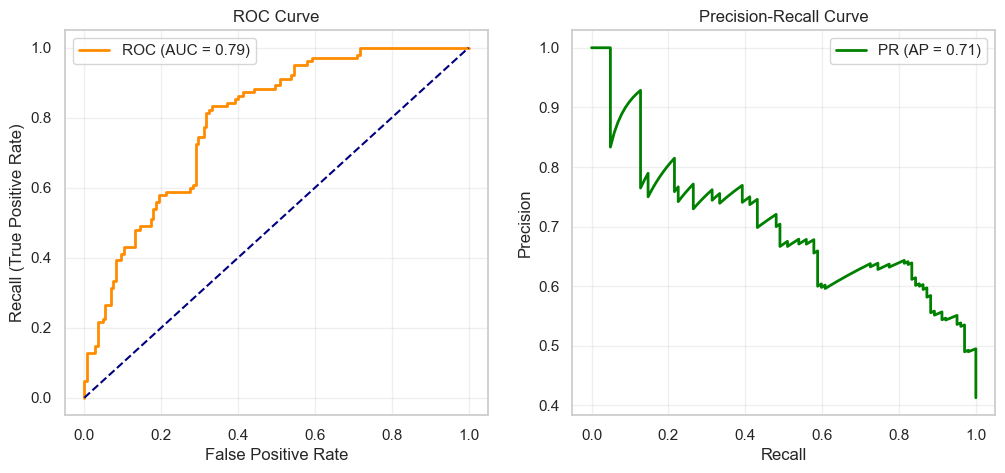


Heatmaps


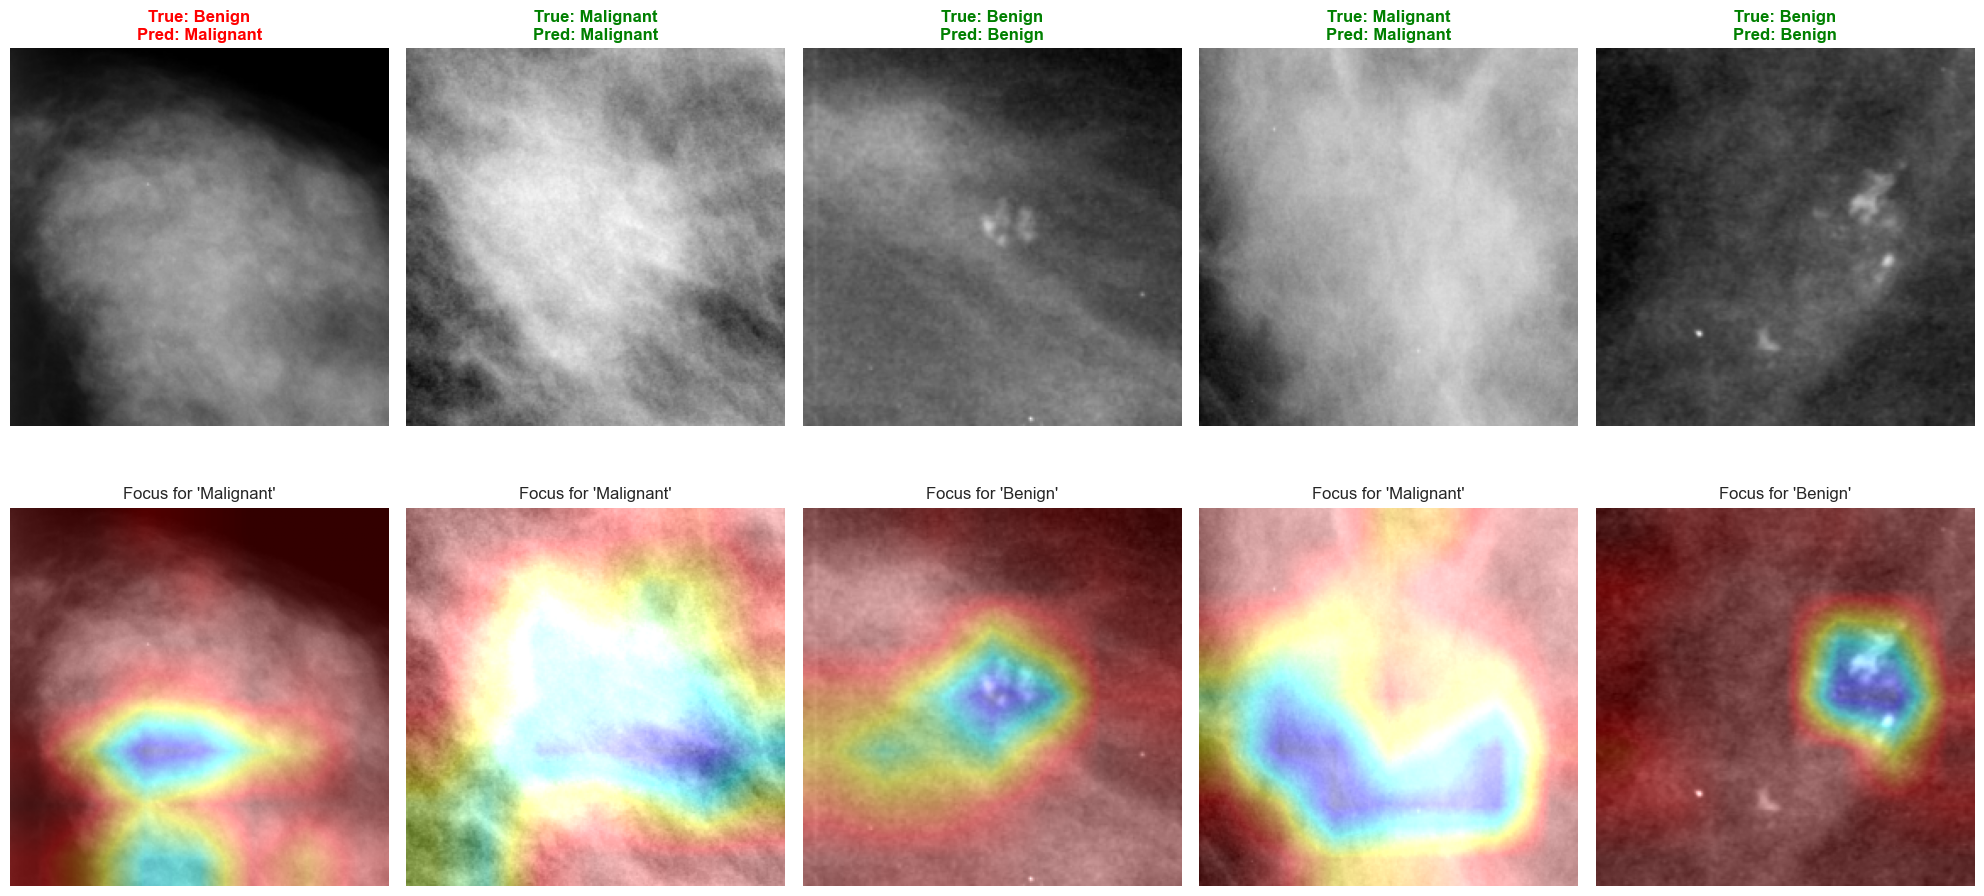

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import cv2

def clear_hooks(model):
    for module in model.modules():
        if hasattr(module, "_forward_hooks"): module._forward_hooks.clear()
        if hasattr(module, "_backward_hooks"): module._backward_hooks.clear()
clear_hooks(model_eff)

# --- 1. Robust Grad-CAM Class ---
class GradCAM_EffNet:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation_and_grads)

    def save_activation_and_grads(self, module, input, output):
        self.activations = output.detach()
        output.register_hook(self.save_gradients)

    def save_gradients(self, grad):
        self.gradients = grad

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)
            
        target = output[0][class_idx]
        target.backward()
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
        return heatmap

# --- 2. Visualization Function ---
def visualize_model_insights(model, loader, device):
    model.eval()
    
    # A. METRICS (ROC / PR)
    print("Metrics")
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.numpy())

    plt.figure(figsize=(12, 5))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall (True Positive Rate)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR (AP = {pr_auc:.2f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # B. GRAD-CAM (Heatmaps)
    print("\nHeatmaps")
    images, labels = next(iter(loader))
    images = images.to(device)
    
    # Target Layer (Last block of EfficientNet features)
    target_layer = model.features[-1] 
    cam = GradCAM_EffNet(model, target_layer)
    
    # Class Mapping
    class_names = {0: 'Benign', 1: 'Malignant'}
    
    plt.figure(figsize=(20, 10))
    for i in range(min(5, len(images))):
        img_tensor = images[i].unsqueeze(0)
        
        with torch.set_grad_enabled(True):
            output = model(img_tensor)
            _, pred = torch.max(output, 1)
            # Generate map for the PREDICTED class
            heatmap = cam(img_tensor, class_idx=pred.item())
            
        # Process Image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        img_uint8 = (img * 255).astype(np.uint8)
        
        # Process Heatmap
        heatmap = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        overlay = heatmap * 0.4 + img_uint8
        overlay = np.clip(overlay, 0, 255).astype(np.uint8) / 255.0
        
        # Plot Original
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        
        true_lab = class_names[labels[i].item()]
        pred_lab = class_names[pred.item()]
        col = 'green' if pred.item() == labels[i].item() else 'red'
        
        plt.title(f"True: {true_lab}\nPred: {pred_lab}", color=col, fontweight='bold')
        plt.axis('off')
        
        # Plot CAM
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(overlay)
        plt.title(f"Focus for '{pred_lab}'")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    

    clear_hooks(model)

visualize_model_insights(model_eff, val_loader_eff, device)

Scanning model for zombie hooks...
  found forward hook in: features.8
✅ Successfully removed 1 zombie hooks.
Generating predictions for Confusion Matrix...


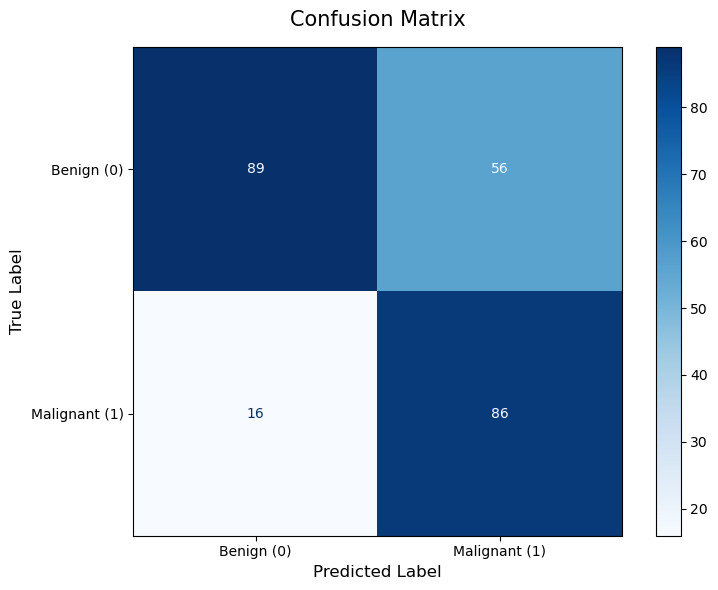

In [ ]:

#test test
def clear_all_hooks(model):
    hook_count = 0
    for name, module in model.named_modules():
        # Clear Forward Hooks
        if hasattr(module, "_forward_hooks"):
            if len(module._forward_hooks) > 0:
                print(f"  found forward hook in: {name}")
                hook_count += len(module._forward_hooks)
                module._forward_hooks.clear()
        
        # Clear Backward Hooks
        if hasattr(module, "_backward_hooks"):
            if len(module._backward_hooks) > 0:
                print(f"  found backward hook in: {name}")
                hook_count += len(module._backward_hooks)
                module._backward_hooks.clear()

    if hook_count > 0:
        print(f"removed {hook_count} hooks.")
    else:
        print("No hook lol.")


clear_all_hooks(model_eff)

plot_custom_confusion_matrix(model_eff, val_loader_eff, device)

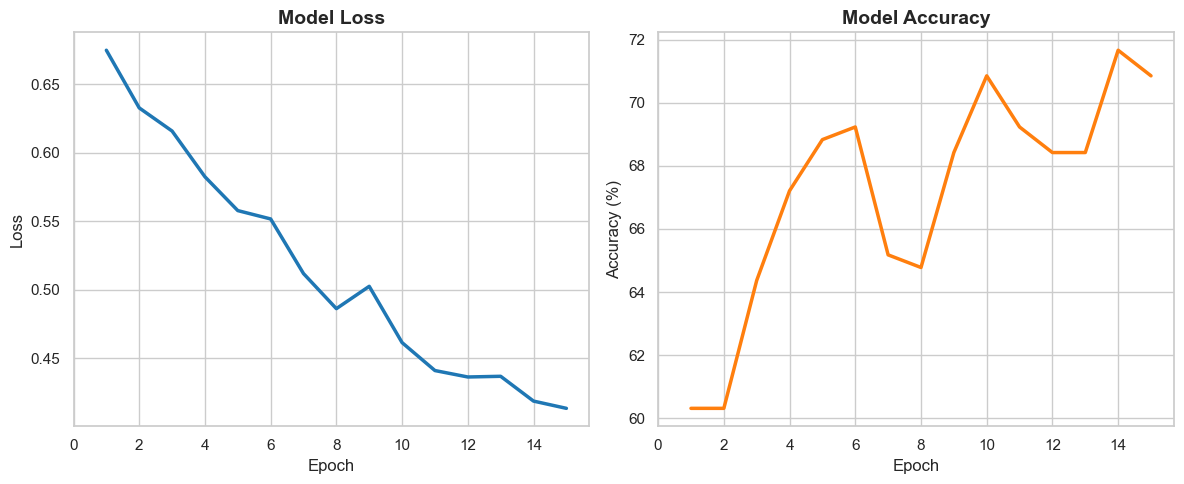

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

epochs = list(range(1, 16))
train_loss = [0.6749, 0.6328, 0.6159, 0.5825, 0.5578, 0.5517, 0.5118, 0.4862, 0.5025, 0.4614, 0.4410, 0.4363, 0.4368, 0.4187, 0.4134]
val_accuracy = [0.6032, 0.6032, 0.6437, 0.6721, 0.6883, 0.6923, 0.6518, 0.6478, 0.6842, 0.7085, 0.6923, 0.6842, 0.6842, 0.7166, 0.7085]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=epochs, y=train_loss, ax=ax[0], color='#1f77b4', linewidth=2.5)
ax[0].set_title('Model Loss', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_xticks(range(0, 16, 2))


val_acc_percent = [x * 100 for x in val_accuracy]
sns.lineplot(x=epochs, y=val_acc_percent, ax=ax[1], color='#ff7f0e', linewidth=2.5)
ax[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xticks(range(0, 16, 2))

plt.tight_layout()
plt.show()

--- Running Ensemble Evaluation (DenseNet + EfficientNet) ---


Ensembling:   0%|          | 0/8 [00:00<?, ?it/s]


--- Ensemble Performance ---
              precision    recall  f1-score   support

      Benign       0.82      0.57      0.67       145
   Malignant       0.57      0.82      0.67       102

    accuracy                           0.67       247
   macro avg       0.70      0.69      0.67       247
weighted avg       0.72      0.67      0.67       247



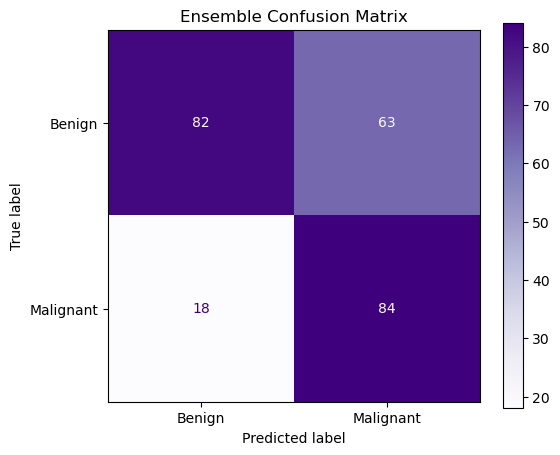

In [ ]:
def evaluate_ensemble(model_a, model_b, loader, device):
    print("--- Running Ensemble Evaluation (DenseNet + EfficientNet) ---")
    model_a.eval()
    model_b.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Ensembling"):
            images, labels = images.to(device), labels.to(device)
            
            # predictions from DenseNet
            out_a = model_a(images)
            probs_a = torch.nn.functional.softmax(out_a, dim=1)
            
            # predictions from EfficientNet
            out_b = model_b(images)
            probs_b = torch.nn.functional.softmax(out_b, dim=1)
            
            avg_probs = (probs_a + probs_b) / 2.0
            
            _, preds = torch.max(avg_probs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Metrics
    print("\n--- Ensemble Performance ---")
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot(cmap=plt.cm.Purples, ax=ax)
    plt.title('Ensemble Confusion Matrix')
    plt.show()

# Run using the loaders from your EfficientNet run
# (Assumes model_v4 and model_eff are still in memory)
evaluate_ensemble(model_v4, model_eff, val_loader_eff, device)

In [28]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2]
}

xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    device="cuda",   
    tree_method="hist",
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1 
)

print(f"Starting GPU-accelerated optimization on {X_train_pca.shape} matrix...")


random_search.fit(X_train_pca, y_train)

print("\nOptimization complete.")
print(f"Best Accuracy: {random_search.best_score_:.4f}")
print("Best Hyperparameters:")
print(random_search.best_params_)
best_model = random_search.best_estimator_
val_predictions = best_model.predict(X_val_pca)

print("\nClassification Report:")
print(classification_report(y_val, val_predictions, target_names=le.classes_))

Starting GPU-accelerated optimization on (988, 50) matrix...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\jrauf\AppData\Local\anaconda3\envs\4600env\lib\site-packages\xgboost\core.py:158: UserWarning: [16:53:05] WARNING: D:\bld\xgboost-split_1744329000128\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

# Baseline Models

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import cv2

print("Extracting data from RAM datasets for Classic ML...")

def extract_flat_data(dataset):
    data = []
    labels = []
    for i in range(len(dataset)):
        img = dataset.images[i]
        img_small = cv2.resize(img, (64, 64)) 
        flat_img = img_small.flatten()
        data.append(flat_img)
        labels.append(dataset.labels[i].item())
    return np.array(data), np.array(labels)

X_train_flat, y_train = extract_flat_data(train_ds)
X_val_flat, y_val = extract_flat_data(val_ds)

print(f"Training Data Shape: {X_train_flat.shape}")
print(f"Validation Data Shape: {X_val_flat.shape}")


print("Scaling and applying PCA...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
print(f"Reduced features from {X_train_flat.shape[1]} to {X_train_pca.shape[1]}")

models = {
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes (Gaussian)": GaussianNB(),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1.0, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

print("\n--- Results ---")
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    preds = model.predict(X_val_pca)
    
    print(f"\n--- {name} Evaluation ---")
    print(classification_report(y_val, preds, target_names=['Benign', 'Malignant']))
    print("-" * 30)

Extracting data from RAM datasets for Classic ML...
Training Data Shape: (988, 12288)
Validation Data Shape: (247, 12288)
Scaling and applying PCA...
Reduced features from 12288 to 50

--- Results ---

--- KNN (k=5) Evaluation ---
              precision    recall  f1-score   support

      Benign       0.63      0.69      0.66       145
   Malignant       0.49      0.43      0.46       102

    accuracy                           0.58       247
   macro avg       0.56      0.56      0.56       247
weighted avg       0.58      0.58      0.58       247

------------------------------

--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

      Benign       0.65      0.70      0.67       145
   Malignant       0.52      0.45      0.48       102

    accuracy                           0.60       247
   macro avg       0.58      0.58      0.58       247
weighted avg       0.59      0.60      0.59       247

------------------------------

--- Naive Ba

c:\Users\jrauf\AppData\Local\anaconda3\envs\4600env\lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:28] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
